# Assignment 2. Language modeling.

This task is devoted to language modeling. Its goal is to write in PyTorch an RNN-based language model. Since word-based language modeling requires long training and is memory-consuming due to large vocabulary, we start with character-based language modeling. We are going to train the model to generate words as sequence of characters. During training we teach it to predict characters of the words in the training set.



## Task 1. Character-based language modeling: data preparation (15 points).

We train the language models on the materials of **Sigmorphon 2018 Shared Task**. First, download the Russian datasets.

In [1]:
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-train-high
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-dev
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-test

--2020-04-08 18:03:16--  https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-train-high
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 533309 (521K) [text/plain]
Saving to: ‘russian-train-high’

russian-train-high  100%[===================>] 520.81K  --.-KB/s    in 0.04s   

2020-04-08 18:03:17 (14.0 MB/s) - ‘russian-train-high’ saved [533309/533309]

--2020-04-08 18:03:20--  https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-dev
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Leng

**1.1 (1 points)**
All the files contain tab-separated triples ```<lemma>-<form>-<tags>```, where ```<form>``` may contain spaces (*будете соответствовать*). Write a function that loads a list of all word forms, that do not contain spaces.  

In [0]:
def read_infile(infile):
    """
    == YOUR CODE HERE ==
    """
    words = []
    with open(infile) as file:
      for line in file:
        form = line.split('\t')[1]
        words.append('_'.join(form.split()))

    return words

In [3]:
train_words = read_infile("russian-train-high")
dev_words = read_infile("russian-dev")
test_words = read_infile("russian-test")
print(len(train_words), len(dev_words), len(test_words))
print(*train_words[:10])

10000 1000 1000
валлонскому незаконченным истрёпывав личного серьгам необоснованным тюти заросла будете_облётывать идеальна


**1.2 (2 points)** Write a **Vocabulary** class that allows to transform symbols into their indexes. The class should have the method ```__call__``` that applies this transformation to sequences of symbols and batches of sequences as well. You can also use [SimpleVocabulary](https://github.com/deepmipt/DeepPavlov/blob/c10b079b972493220c82a643d47d718d5358c7f4/deeppavlov/core/data/simple_vocab.py#L31) from DeepPavlov. Fit an instance of this class on the training data.

In [4]:
! pip install deeppavlov

     |████████████████████████████████| 757kB 4.6MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 2.1MB 20.5MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 1.5MB 40.9MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 8.0MB 15.0MB/s 
     |████████████████████████████████| 10.4MB 54.1MB/s 
     |████████████████████████████████| 7.3MB 21.2MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 6.7MB 39.0MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
     |████████████████████████████████| 20.1MB 152kB/s 
     |████████████████████████████████| 7.1MB 18.8MB/s 
     |████████████████████████████████| 2.7MB 53.1MB/s 
     |██

In [5]:
from deeppavlov.core.data.simple_vocab import SimpleVocabulary
"""
== YOUR CODE HERE ==
"""

vocab = SimpleVocabulary(save_path='/content')
vocab.fit([list(x) for x in train_words])#  + ['BEGIN', 'END'])
print(len(vocab))

BEGIN_INDEX = len(vocab)
END_INDEX = len(vocab) + 1

2020-04-08 18:04:12.996 WARNING in 'deeppavlov.core.models.serializable'['serializable'] at line 49: No load path is set for SimpleVocabulary in 'infer' mode. Using save path instead


52


**1.3 (2 points)** Write a **Dataset** class, which should be inherited from ```torch.utils.data.Dataset```. It should take a list of words and the ```vocab``` as initialization arguments.

In [6]:
import torch
t = torch.Tensor([1, 2, 3])
print(t)

tensor([1., 2., 3.])


In [0]:
import torch
from torch.utils.data import Dataset as TorchDataset

class Dataset(TorchDataset):
    
    """Custom data.Dataset compatible with data.DataLoader."""
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab

    def __getitem__(self, index):
        """
        Returns one tensor pair (source and target). The source tensor corresponds to the input word,
        with "BEGIN" and "END" symbols attached. The target tensor should contain the answers
        for the language model that obtain these word as input.        
        """
        
        indexed_word = [vocab[char] for char in self.data[index]]
        return torch.Tensor([BEGIN_INDEX] + indexed_word), torch.Tensor(indexed_word + [END_INDEX])

    def __len__(self):
        return len(self.data)

In [0]:
train_dataset = Dataset(train_words, vocab)
dev_dataset = Dataset(dev_words, vocab)
test_dataset = Dataset(test_words, vocab)

**1.4 (3 points)** Use a standard ```torch.utils.data.DataLoader``` to obtain an iterable over batches. Print the shape of first 10 input batches with ```batch_size=1```.

In [9]:
from torch.utils.data import DataLoader

dl = DataLoader(train_dataset)
i = 0
for tests, test_labels in dl:  
  print(tests.shape)
  
  i += 1
  if i == 10:
    break

torch.Size([1, 12])
torch.Size([1, 14])
torch.Size([1, 11])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 15])
torch.Size([1, 5])
torch.Size([1, 8])
torch.Size([1, 18])
torch.Size([1, 9])


**(1.5) 1 point** Explain, why this does not work with larger batch size.

It is well known that too large of a batch size will lead to poor generalization (although currently it’s not known why this is so)

**(1.6) 5 points** Write a function **collate** that allows you to deal with batches of greater size. See [discussion](https://discuss.pytorch.org/t/dataloader-for-various-length-of-data/6418/8) for an example. Implement your function as a class ```__call__``` method to make it more flexible.

In [0]:
def pad_tensor(vec, length, dim, pad_symbol):
    """
    Pads a vector ``vec`` up to length ``length`` along axis ``dim`` with pad symbol ``pad_symbol``.
    """

    pad_size_list = list(vec.shape)
    pad_size_list[dim] = length - vec.size(dim)
    padding = torch.Tensor().new_full(tuple(pad_size_list), pad_symbol)
    return torch.cat([vec, padding], dim=dim)

class Padder:
    def __init__(self, dim=0, pad_symbol=0):
        self.dim = dim
        self.pad_symbol = pad_symbol
        

    def pad_collate(self, batch):
        """
        args:
            batch - list of (tensor, label)

        return:
            xs - a tensor of all examples in 'batch' after padding
            ys - a LongTensor of all labels in batch
        """


        # find longest sequence
        max_len = max(map(lambda x: x[0].shape[self.dim], batch))
        def decorated_pad_tensor(tensor):
          return pad_tensor(tensor, length=max_len, dim=self.dim, pad_symbol=self.pad_symbol)
        # pad according to max_len
        # batch = map(lambda sample_and_label: (pad_tensor(sample_and_label[0], length=max_len, dim=self.dim, pad_symbol=self.pad_symbol), sample_and_label[1]), batch)

        # stack all
        xs = torch.stack(tuple(map(lambda x: decorated_pad_tensor(x[0]), batch)), dim=self.dim).type(torch.LongTensor)
        ys = torch.stack(tuple(map(lambda x: decorated_pad_tensor(x[1]), batch)), dim=self.dim).type(torch.LongTensor)
        mask = torch.stack([pad_tensor(torch.ones(y.shape), max_len, self.dim, 0) for y in ys]).type(torch.LongTensor)

        return xs, ys, mask
        
    def __call__(self, batch):
        return self.pad_collate(batch)

**(1.7) 1 points** Again, use ```torch.utils.data.DataLoader``` to obtain an iterable over batches. Print the shape of first 10 input batches with the batch size you like.

In [11]:
from torch.utils.data import DataLoader

dataset = DataLoader(train_dataset, collate_fn=Padder(pad_symbol=END_INDEX), batch_size=20, shuffle=True)
i = 0
for tests, test_labels, mask in dataset:  
  print(tests.shape, test_labels.shape)
  
  i += 1
  if i == 10:
    break

torch.Size([20, 21]) torch.Size([20, 21])
torch.Size([20, 19]) torch.Size([20, 19])
torch.Size([20, 25]) torch.Size([20, 25])
torch.Size([20, 16]) torch.Size([20, 16])
torch.Size([20, 15]) torch.Size([20, 15])
torch.Size([20, 16]) torch.Size([20, 16])
torch.Size([20, 18]) torch.Size([20, 18])
torch.Size([20, 15]) torch.Size([20, 15])
torch.Size([20, 18]) torch.Size([20, 18])
torch.Size([20, 20]) torch.Size([20, 20])


## Task 2. Character-based language modeling. (35 points)

**2.1 (5 points)** Write a network that performs language modeling. It should include three layers:
1. **Embedding** layer that transforms input symbols into vectors.
2. An **RNN** layer that outputs a sequence of hidden states (you may use https://pytorch.org/docs/stable/nn.html#gru).
3. A **Linear** layer with ``softmax`` activation that produces the output distribution for each symbol.

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class RNNLM(nn.Module):

    def __init__(self, vocab_size, embeddings_dim, hidden_size):
        super(RNNLM, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embeddings_dim)
        self.rnn = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size

      
    def forward(self, inputs, hidden=None):
        embedded = self.embedding(inputs)
        rnn_out, hidden = self.rnn(embedded)#, torch.zeros(1, inputs[0].shape[0], self.hidden_size))
        output = self.linear(rnn_out)
        
        return output
        # print(torch.tensor([max(char_weights) for char_weights in output]))
        #return torch.tensor([torch.argmax(char_weights) for char_weights in output[0]])

**2.2 (1 points)** Write a function ``validate_on_batch`` that takes as input a model, a batch of inputs and a batch of outputs, and the loss criterion, and outputs the loss tensor for the whole batch. This loss should not be normalized.

In [0]:
def validate_on_batch(model, criterion, x, y):
    y = y.view(-1)
    scores = model(x)
    scores = scores.view(-1, scores.shape[-1])
    loss = criterion(scores, y)
    return loss

**2.3 (1 points)** Write a function ``train_on_batch`` that accepts all the arguments of ``validate_on_batch`` and also an optimizer, calculates loss and makes a single step of gradient optimization. This function should call ``validate_on_batch`` inside.

In [0]:
def train_on_batch(model, criterion, x, y, mask, optimizer):
    loss = validate_on_batch(model, criterion, x, y)
    nopad_chars = mask.sum()
    loss = (loss * mask.view(-1)).sum() / nopad_chars

    # Zero grads
    optimizer.zero_grad()
    # Backpropagate
    loss.backward()
    # Update weights
    optimizer.step()
    return loss

**2.4 (3 points)** Write a training loop. You should define your ``RNNLM`` model, the criterion, the optimizer and the hyperparameters (number of epochs and batch size). Then train the model for a required number of epochs. On each epoch evaluate the average training loss and the average loss on the validation set. 

**2.5 (3 points)** Do not forget to average your loss over only non-padding symbols, otherwise it will be too optimistic.

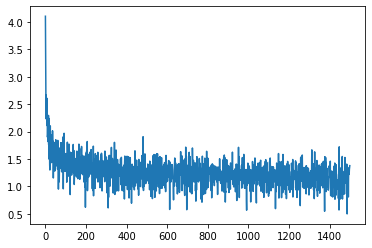

In [15]:
import matplotlib.pyplot as plt
import numpy as np
epoch_num = 3
embedding_dim = 300
hidden_dim = 300
vocab_size = len(vocab) +2
lr = 1e-3

criterion = torch.nn.CrossEntropyLoss()
model = RNNLM(vocab_size, embedding_dim, hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

losses = []

for epoch in range(epoch_num):
  for x, y, mask in dataset:
    loss = train_on_batch(model, criterion, x, y, mask, optimizer)
    # print('Loss: {:6.4f}'.format(loss.item()))
    losses.append(loss.item())


plt.plot(losses)
  # with torch.no_grad():
  #   matches, total = 0, 0
  #   for x, y, mask in dataset:
  #     _, batch_out = predictions.max(dim=1)

  #     # Remove batch
  #     batch_out = batch_out.squeeze(1)

  #     # Calculate accuracy
  #     matches += torch.eq(batch_out, y).sum().item()
  #     total += torch.numel(batch_out)
  
  # accuracy = matches / total




  # plt.title('Accuracy: {:4.2f}%'.format(accuracy * 100))

  # plt.plot(range(1, len(vocab)), (np.arange(1, len(vocab)) - 10) %  len(vocab))
  # with torch.no_grad():
  #     plt.plot(range(1, len(vocab)), F.softmax(model(torch.tensor(range(1, len(vocab)))), 1).max(dim=1)[1])
  # plt.show()

**2.6 (5 points)** Write a function **predict_on_batch** that outputs letter probabilities of all words in the batch.

In [0]:
def predict_on_batch(x, model):
    out = model(x)
    return torch.softmax(out, dim=-1)

**2.7 (1 points)** Calculate the letter probabilities for all words in the test dataset. Print them for 20 last words. Do not forget to disable shuffling in the ``DataLoader``.

In [17]:
data_loader = DataLoader(train_dataset, collate_fn=Padder(pad_symbol=END_INDEX), batch_size=20)

for x, y, mask in data_loader:
  out = predict_on_batch(x, model)

for i in range(1, 21):
  print(out[-i])


tensor([[8.2360e-02, 3.5978e-02, 3.7318e-03,  ..., 5.0180e-05, 5.8638e-05,
         6.9420e-04],
        [2.2199e-01, 3.5644e-02, 5.1312e-02,  ..., 4.9920e-05, 4.8833e-05,
         1.8221e-04],
        [1.2899e-02, 7.2415e-03, 6.1174e-02,  ..., 1.0374e-04, 7.5210e-05,
         7.4501e-04],
        ...,
        [1.6743e-07, 1.4894e-07, 7.4860e-07,  ..., 2.9917e-08, 4.4029e-08,
         9.9997e-01],
        [1.6685e-07, 1.4890e-07, 7.3603e-07,  ..., 2.9862e-08, 4.4072e-08,
         9.9997e-01],
        [1.6639e-07, 1.4878e-07, 7.2549e-07,  ..., 2.9796e-08, 4.4073e-08,
         9.9997e-01]], grad_fn=<SelectBackward>)
tensor([[8.2360e-02, 3.5978e-02, 3.7318e-03,  ..., 5.0180e-05, 5.8638e-05,
         6.9420e-04],
        [3.3387e-01, 1.3861e-01, 8.6948e-02,  ..., 2.4439e-05, 1.3735e-05,
         1.5135e-05],
        [6.6381e-03, 2.1928e-03, 7.5025e-03,  ..., 7.3370e-05, 6.8939e-05,
         1.0687e-03],
        ...,
        [1.6378e-07, 1.6295e-07, 7.3299e-07,  ..., 2.7847e-08, 4.0810e-08,

**2.8 (5 points)** Write a function that generates a single word (sequence of indexes) given the model. Do not forget about the hidden state! Be careful about start and end symbol indexes. Use ``torch.multinomial`` for sampling.

In [0]:
def generate(model, max_length=20, start_index=BEGIN_INDEX, end_index=END_INDEX):
    """
    == YOUR CODE HERE ==
    """

    for i in range(max_length):
      input = torch.full((1, 1), start_index, dtype=torch.long)
      output = model(input)
      #print(output[0][0].shape)
      probab = torch.softmax(output, -1).reshape(-1)
      #print(probab.shape)
      generated = torch.multinomial(probab, 1).item()
      #print(generated)
      if generated == end_index:
        break

      if generated == start_index:
        generated = ''

      yield generated

def index_to_char(index):
    index_to_char = vocab._i2t.copy()
    # print(index)
    return index_to_char[index]

**2.9 (1 points)** Use ``generate`` to sample 20 pseudowords. Do not forget to transform indexes to letters.

In [38]:
for i in range(20):
    print(''.join([index_to_char(index) for index in generate(model)]))

нмозксвнирппсцосуанн
зрбубсдуообсокучжзоо
пгцписоприппугнарбор
иобзпуосбзоцзмнагрсо
пВслкоилпроивфабрумп
бпндвпадопуоппнниаик
ущшвпабкпипрчзтпгкбб
пуппбврргоппцоуптппп
жммзорбскркотопвзоез
пбпппбруспапррзвпочп
мббпвпрпурмопбпснамс
тупорпдбпнсспмпипаки
гкпаорвзбббпдовпнрип
убсочвмнвпсдркртубдк
ряаонсбкнкаумзп
аспддоббуизорнвосвпс
снпсомцмолзрпакубппв
нпаорпуупикквтаансзв
вкаивсбввсзпрзцрроуя
исдикмпнбркогвмудспв


**(2.10) 5 points** Write a batched version of the generation function. You should sample the following symbol only for the words that are not finished yet, so apply a boolean mask to trace active words.

In [0]:
from copy import copy
from itertools import filterfalse

def generate_batch(model, batch_size, max_length = 20, start_index=1, end_index=2):
    symbols = torch.full((batch_size, 1), start_index).type(torch.LongTensor)
    indexs = [copy(symbols)]

    active_words = np.ones(batch_size, dtype=np.bool)

    for i in range(max_length):
        prediction = model(symbols[active_words])
        probability = torch.softmax(prediction, -1)
        probability = probability.reshape(-1, probability.shape[-1])

        symbols[active_words] = torch.multinomial(probability, 1)
        indexs.append(copy(symbols))
        active_words = symbols.numpy().reshape(-1) != end_index

    return torch.stack(indexs, axis=1).squeeze_(-1)
    



In [36]:
generated = []
for _ in range(2):
    generated += generate_batch(model, batch_size=10)

print(generated)
generated = [[index_to_char(index) for index in tensor] for tensor in generated]
print(generated)
"""
== YOUR CODE HERE ==
"""
for elem in generated:
    print("".join(elem))

[tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]), tensor([17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17]), tensor([53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
        53, 53, 53]), tensor([21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
        21, 21, 21]), tensor([53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
        53, 53, 53]), tensor([53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
        53, 53, 53]), tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]), tensor([21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
        21, 21, 21]), tensor([53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
        53, 53, 53]), tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10]), tensor([53, 53, 53, 53, 53, 53, 53, 5

IndexError: ignored

**(2.11) 5 points** Experiment with the type of RNN, number of layers, units and/or dropout to improve the perplexity of the model.